# Statystyka stosowana - Raport 2  
**Emil Olszewski**

## Testowanie hipotez statystycznych

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd 
import random

In [151]:
plt.style.use("seaborn-v0_8-notebook")

In [18]:
def load_data(path: str):

    df: pd.DataFrame = pd.read_csv(path, header=None)
    return np.array(df[0])
    

### Zadanie 1

In [130]:
data1 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad1.txt")

In [161]:
def plot_test(z, lower_bound=None, upper_bound=None):

    xs = np.arange(-3, 3, 0.1)
    ys = st.norm.pdf(xs)
    p = plt.plot(xs, ys, label="Gęstość N(0, 1)")

    if lower_bound:
        plt.plot(
            [lower_bound, lower_bound],
            [0, st.norm.pdf(lower_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(-3, lower_bound + 0.1, 0.1),
            0,
            st.norm.pdf(np.arange(-3, lower_bound + 0.1, 0.1)),
            facecolor="red", 
            label="Zbiór krytyczny"
        )

    if upper_bound:
        plt.plot(
            [upper_bound, upper_bound],
            [0, st.norm.pdf(upper_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(upper_bound, 3, 0.1),
            0,
            st.norm.pdf(np.arange(upper_bound, 3, 0.1)),
            facecolor="red",
            label=None if lower_bound else "Zbiór krytyczny"
        )
        
    if -3 <= z <= 3:
        plt.plot([z, z], [0, st.norm.pdf(z)], c="orange")
    
    plt.grid(True)
    plt.legend()

    return p

In [165]:
def stat_test(
        mean,                    # wartość oczekiwana rozkładu przy założeniu hipotezy zerowej
        std,                     # odchylenie standardowe rozkładu (znane)
        alfa,                    # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):

    # Statystyka testowa, posiadająca rozkład N(0, 1) przy założeniu prawdziwości H0
    z = (np.mean(sample) - mean) * np.sqrt(len(sample)) / std

    if alternative == "not_equal":
        lower_bound = st.norm.ppf(alfa/2)
        upper_bound = -lower_bound          # Ze względu na symetryczność rozkładu N(0, 1) kwantyl rzędu a/2 to -1 * kwantyl rzędu 1 - a/2
    elif alternative == "less":
        lower_bound = st.norm.ppf(alfa)
        upper_bound = None
    elif alternative == "greater":
        lower_bound = None
        upper_bound = st.norm.ppf(1 - alfa)
    else:
        raise Exception("Podano nieprawidłową hipotezę alternatywną")


    # p-wartość 

    # p-wartość to taka wartość poziomu istotności testu statystycznego, że
    # statystyka testowa równa się wartości krytycznej testu.

    if alternative == "not_equal": 
        if z >= 0:
            pvalue = 2 * (1 - st.norm.cdf(z))
        else:
            pvalue = 2 * st.norm.cdf(z)
    elif alternative == "less":
        pvalue = st.norm.cdf(z)
    else:
        pvalue = 1 - st.norm.cdf(z)

    alt_hypo = "mu != 1.5" if alternative == "not_equal" else (
               "mu < 1.5" if alternative == "less" else "mu > 1.5"
    )

    print(f"p-wartość (dla H1: {alt_hypo}): {pvalue}")

    return plot_test(z, lower_bound, upper_bound)

p-wartość (dla H1: mu != 1.5): 1.902482582482688e-12


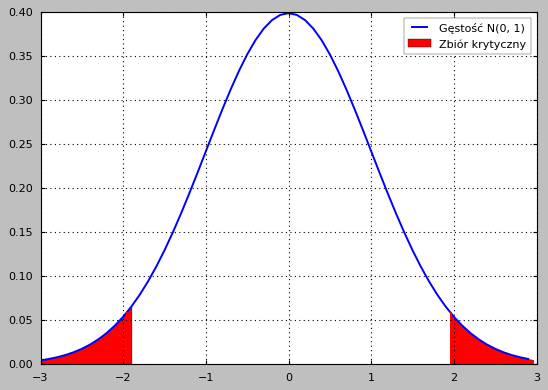

In [166]:
plt.show(stat_test(1.5, 0.05, 0.2, data1, alternative="not_equal"))

p-wartość (dla H1: mu < 1.5): 9.51241291241344e-13


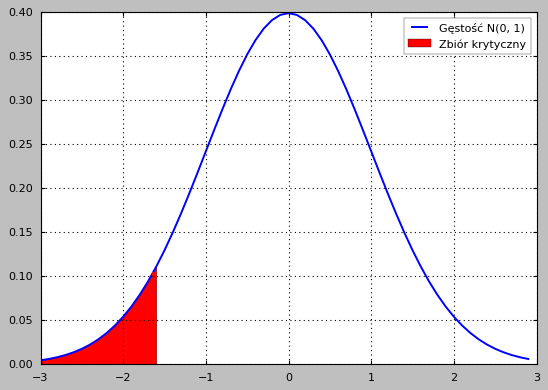

In [167]:
plt.show(stat_test(1.5, 0.05, 0.2, data1, alternative="less"))

p-wartość (dla H1: mu > 1.5): 0.9999999999990488


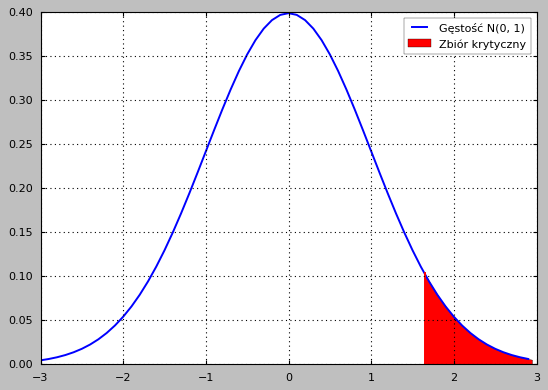

In [168]:
plt.show(stat_test(1.5, 0.05, 0.2, data1, alternative="greater"))

In [67]:
st.norm.pdf((np.mean(data1) - 1.5) / 0.2 * np.sqrt(1000))

6.8282416608723724e-12

### Zadanie 2

In [35]:
data2 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad2.txt")
np.std(data2)

1.2909115668210043